In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier , VotingClassifier
from lightgbm import LGBMClassifier



RANDOM_SEED = 42

## **DATA LOADING**

In [2]:
traindata = pd.read_csv( "train.csv" )
valdata = pd.read_csv( "val.csv" )
testdata  = pd.read_csv( "test.csv" )

In [3]:
#make summary DataFrame to check data

summary = pd.DataFrame({
    'unique_values': traindata.nunique(),
    'missing_values': traindata.isnull().sum(),
    'dtype': traindata.dtypes
})

# store original lengths of each dataset for splitting later
n_train = len(traindata)
n_val   = len(valdata)
n_test  = len(testdata)

df = pd.concat([traindata, valdata, testdata], axis=0, ignore_index=True)
print(df.head())


   p1  p2  p3  p4  p5  p6  p7  p8  p9  p10  ...  p36  p37  p38  p39  p40  p41  \
0   0   1  -1   1  -1   0   1   0   1   -1  ...    0    0    0    0    0    0   
1   0  -1  -1   1   0   0   0   0   1    0  ...    0    0    0    0    0    0   
2   0   1  -1   1   0   0   1   0   0   -1  ...    0    0    0    0    0    0   
3   1   0   0   0  -1   1   1  -1   0    0  ...    0    0    0    0    0    0   
4   1   1  -1  -1  -1   1  -1   1   0    0  ...   -1    0    0    0    0    0   

   p42  turn  label_move_col  id  
0    0     1             1.0 NaN  
1    0    -1             1.0 NaN  
2    0    -1             2.0 NaN  
3    0    -1             3.0 NaN  
4    1    -1             4.0 NaN  

[5 rows x 45 columns]


## **HELPER FUNCTIONS**

In [4]:
def normalize_perspective(df):
    """
    flip the board so that '1' is always the current player
    """
    df = df.copy()
    feat_cols = [f"p{i}" for i in range(1, 43)] # columns

    boards = df[feat_cols].to_numpy().reshape(-1, 6, 7) # reshape to 6x7 boards

    # count pieces for each board
    count_1 = (boards == 1).sum(axis=(1,2))
    count_m1 = (boards == -1).sum(axis=(1,2))

    # if opponent turn
    mask = count_m1 > count_1  

    boards[mask] *= -1  # swap perspective

    # put back into dataframe and reshape
    df[feat_cols] = boards.reshape(-1, 42)

    return df

In [5]:
def calculate_score(board, player):
    """
    takes the 6x7 board array and the 'player' (1 or -1)    
    
    """
    score = 0  # score for the player
    lines = [] # store the coordinates of all 69 possible winning lines
 
    # find all 69 possible winning lines
    
# 1) GENERATING ALL 4-SQUARE WINDOWS
    
    # Horizontal (4 per row, 6 rows total)
    for r in range(6): 
        for c in range(4):
            lines.append([(r, c+i) for i in range(4)])
            
    # Vertical (3 per column, 7 columns total)       
    for c in range(7): 
        for r in range(3):
            lines.append([(r+i, c) for i in range(4)])
            
    # Diagonal (/)        
    for r in range(3): 
        for c in range(4):
            lines.append([(r+i, c+i) for i in range(4)])

    # Diagonal (\)
    for r in range(3, 6): # Diagonal (\)
        for c in range(4):
            lines.append([(r-i, c+i) for i in range(4)])

# 2) SCORING

    for line in lines: #loop through all possible winning lines
        p_pieces = 0
        o_pieces = 0
        
        for r, c in line: # loop through the 4 coords (r, c) of the current line
            piece = board[r, c]
            if piece == player: # count pieces the player has in this line
                p_pieces += 1
            elif piece == -player: # count pieces the opponent has in this line
                o_pieces += 1
        
        # score lines that are not blocked by the opponent
        if o_pieces == 0: # no opp peices are in line
            if p_pieces == 3:
                score += 100 # high score for 3-in-a-row (threat potential)
            elif p_pieces == 2:
                score += 10  # lower score for 2-in-a-row
            elif p_pieces == 1:
                score += 1   # Lowest score for 1-in-a-row
                
    return score

## **FEATURE ENGINEERING**

In [6]:
def create_features(df_original):
    """
     creates only basic positional and score features.
    """
    df = df_original.copy()
    feat_cols = [f"p{i}" for i in range(1, 43)]
    X = df[feat_cols].to_numpy()
    boards = X.reshape(-1, 6, 7)
    heights = (boards != 0).sum(axis=1)

    # --- Basic Features ---
    df["center_open"] = (heights[:, 3] < 6)
    
    for j in range(7):
        df[f"h{j+1}"] = heights[:, j]
    
    # --- Score Lists  ---
    player_score_list = []
    opp_score_list = []

    for i in tqdm(range(len(boards)), desc="Creating Features..."):
        b = boards[i]             
        
        # Calculate Score 
        player_score_list.append(calculate_score(b, 1))
        opp_score_list.append(calculate_score(b, -1))

        
    df["score_p"] = player_score_list
    df["score_o"] = opp_score_list


        
    return df 

## **DATA PREPROCESSING**

In [7]:

# Normalize
train_norm = normalize_perspective(traindata)
val_norm   = normalize_perspective(valdata)
test_norm  = normalize_perspective(testdata)


# Create features for all 3 datasets

train_final = create_features(train_norm) 
valid_final = create_features(val_norm) 
test_final  = create_features(test_norm)

# Convert boolean features to int
for df in [train_final, valid_final, test_final]:
    for col in df.select_dtypes('bool').columns:
        df[col] = df[col].astype(int)

# Get X and y
X_train = train_final.drop("label_move_col", axis=1)
y_train = train_final["label_move_col"]

X_valid = valid_final.drop("label_move_col", axis=1)
y_valid = valid_final["label_move_col"]



Creating Features...: 100%|██████████| 10868/10868 [00:01<00:00, 7108.30it/s]


## **Ensemble MODEL TRAINING (XGB + LGBM + RF)**

In [8]:
print("Training the Ensemble model....")

# --- Model 1: XGBoost ---
# we use the best params we found

clf1 = XGBClassifier(
    objective="multi:softmax",
    num_class=7,
    random_state=42,
    learning_rate=0.2,
    max_depth=9,
    n_estimators=400,
    n_jobs=-1
)

# --- Model 2: LightGBM  ---
# similar powerful parameters

clf2 = LGBMClassifier(
    objective="multiclass",
    num_class=7,
    random_state=42,
    learning_rate=0.2,
    max_depth=9,
    n_estimators=400,
    n_jobs=-1
)

# --- Model 3: Random Forest  ---
# think differently than boosting models (like XGB/LGBM), gives diversity

clf3 = RandomForestClassifier(
    n_estimators=400,  # RFs need a lot of trees
    max_depth=15,      # RFs can be deeper
    random_state=42,
    n_jobs=-1
)

# --- The Ensemble: VotingClassifier ---
# combine all three using 'soft' voting
# add weight and we give XGBoost (clf1) the most since we trust it the most

eclf = VotingClassifier(
    estimators=[
        ('xgb', clf1), 
        ('lgbm', clf2),
        ('rf', clf3)
    ],
    voting='soft',  
    weights=[0.5, 0.3, 0.2]  # XGB 50% 
)


eclf.fit(X_train, y_train)

xgb = eclf

print("Ensemble training complete.")

Training the Ensemble model....
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 690
[LightGBM] [Info] Number of data points in the train set: 49993, number of used features: 53
[LightGBM] [Info] Start training from score -1.946731
[LightGBM] [Info] Start training from score -2.498217
[LightGBM] [Info] Start training from score -2.317965
[LightGBM] [Info] Start training from score -1.040977
[LightGBM] [Info] Start training from score -2.317965
[LightGBM] [Info] Start training from score -2.498217
[LightGBM] [Info] Start training from score -1.946731
Ensemble training complete.


## **EVALUATION**

In [9]:
# predict on original validation set
print("Evaluating model...")

val_pred = xgb.predict(valid_final.drop("label_move_col", axis=1))

print(accuracy_score (y_valid, val_pred) )

Evaluating model...
0.656116576944496


In [10]:
# --- Feature Importance ---
print("--- Feature Importances for the ENSEMBLE ---")

# we ask our main 'xgb' model inside the ensemble
xgb_inner_model = xgb.named_estimators_['xgb']

feat_names = X_train.columns

importances = xgb_inner_model.feature_importances_

imp_series = pd.Series(importances, index=feat_names)

# Sort the series from highest to lowest
imp_sorted = imp_series.sort_values(ascending=False)

print("\n--- Sorted Importances (from the XGBoost model) ---")
print(imp_sorted)


--- Feature Importances for the ENSEMBLE ---

--- Sorted Importances (from the XGBoost model) ---
h4             0.062020
center_open    0.039635
p27            0.024468
p23            0.024055
p4             0.023835
p33            0.022254
p24            0.021651
p31            0.021405
p26            0.021350
p17            0.020363
p19            0.020103
p29            0.019443
h3             0.018943
p5             0.018751
h5             0.018643
p3             0.018618
p34            0.018536
turn           0.018418
p30            0.018386
score_p        0.018300
p2             0.018273
p20            0.018122
p16            0.018029
p35            0.017982
h1             0.017945
h7             0.017844
p6             0.017763
p41            0.017657
p13            0.017497
p9             0.017469
p37            0.017315
score_o        0.016636
p10            0.016311
h2             0.016305
p28            0.016250
p12            0.016192
h6             0.016127
p22           

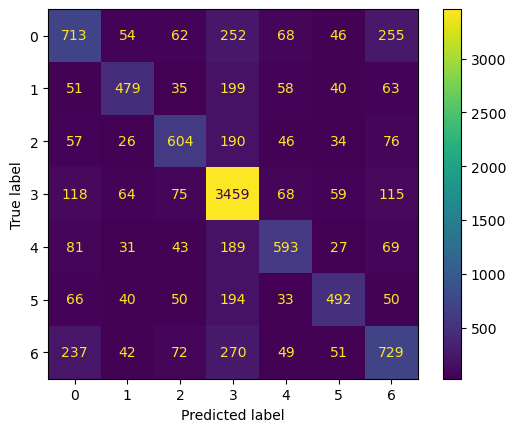

0.656116576944496


In [11]:
# --- Confusion Matrix ---

xgb_CM = confusion_matrix(y_valid, val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=xgb_CM, display_labels= xgb.classes_)
disp.plot()
plt.show()

print(accuracy_score(y_valid,val_pred))

## **Save the test predictions to CSV file to submitted to kaggle**

In [12]:
print("Creating submission file...")

X_test_final = test_final[X_train.columns]

test_predictions = xgb.predict(X_test_final)

# new DataFrame for the submission
submit = pd.DataFrame({
    'id': testdata['id'],  # 'id' column from the original test data
    'label_move_col': test_predictions # use our model's predictions
})

# turn columns to integers to match the submission format
submit['id'] = submit['id'].astype(int)
submit['label_move_col'] = submit['label_move_col'].astype(int)

# save DataFrame to a CSV file
submit.to_csv('SubmissionEnsembleNew.csv', index=False)

print("Submission file created: 'SubmissionEnsembleNew.csv'")
print(submit.head())

Creating submission file...
Submission file created: 'SubmissionEnsembleNew.csv'
   id  label_move_col
0   1               2
1   2               3
2   3               4
3   4               3
4   5               3
